# Text Sumarry

## Word Frequency Analysis

Total words: 170972
Word Frequencies: [('langdon', 1578), ('sophie', 1125), ('teabing', 601), ('said', 535), ('could', 436), ('fache', 398), ('would', 396), ('one', 321), ('grail', 289), ('back', 282), ('silas', 271), ('like', 254), ('man', 253), ('grandfather', 243), ('sauniere', 234), ('felt', 234), ('church', 223), ('eyes', 216), ('looked', 216), ('know', 200), ('see', 192), ('collet', 181), ('aringarosa', 181), ('priory', 174), ('thought', 171), ('remy', 170), ('robert', 169), ('turned', 164), ('keystone', 164), ('even', 161), ('still', 160), ('floor', 156), ('holy', 151), ('time', 148), ('right', 148), ('toward', 146), ('teacher', 145), ('door', 145), ('room', 143), ('two', 140), ('key', 137), ('tonight', 136), ('knew', 135), ('something', 134), ('head', 132), ('tell', 131), ('yet', 131), ('seemed', 130), ('da', 129), ('police', 129), ('left', 129), ('vinci', 127), ('moment', 127), ('box', 126), ('secret', 125), ('never', 125), ('told', 124), ('chapter', 124), ('made', 123), ('acr

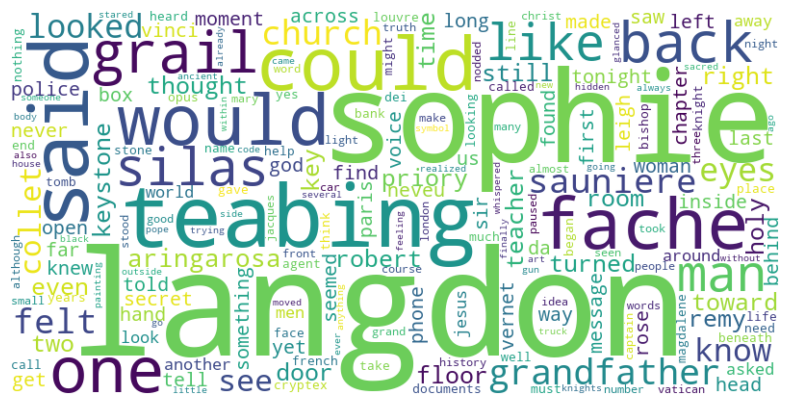

In [9]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from wordcloud import WordCloud
import matplotlib.pyplot as plt

stop_words = set(stopwords.words('english'))

# read the text from the txt file
with open("books/The_DaVinci_Code.txt") as f:
    text = f.read()

def word_count(text):

    words = [word for word in word_tokenize(text.lower()) if word.isalpha() and word not in stop_words]

    freq_dist = FreqDist(words)

    return freq_dist

words = word_tokenize(text)
print(f"Total words: {len(words)}")

freq_dist = word_count(text)

print("Word Frequencies:", freq_dist.most_common())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dist)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Sentiment Analysis By naive bayes

Average Sentiment: 0.5036013257575758


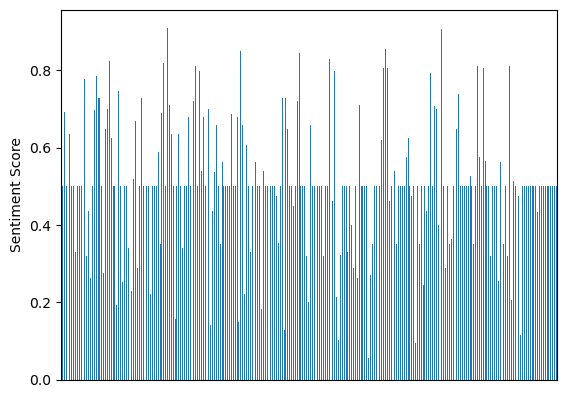

In [26]:
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
sia = SentimentIntensityAnalyzer()

with open("Final_summaries.txt") as f:
    summary_text = f.read()

# Divide the text into sentences
sentences = nltk.sent_tokenize(summary_text)

# save the sentiment to a xlsx file 
df = pd.DataFrame(sentences, columns=['sentence'])
df['sentiment'] = df['sentence'].apply(lambda x: sia.polarity_scores(x))
# Convert the sentiment to a number between 0 and 1
# let df['sentiment']+1 to make the sentiment between 0 and 2
df['sentiment'] = df['sentiment'].apply(lambda x: (x['compound']+1)/2)

df.to_excel("sentiment_Navie_Bayes.xlsx", index=False)


print("Average Sentiment:", df['sentiment'].mean())

#draw a bar chart
df['sentiment'].plot(kind='bar')
# Ignore the x-axis labels
plt.xticks([])
plt.ylabel("Sentiment Score")
plt.show()


## Text Sumarry by Pretrained LLM

In [33]:
import torch
from nltk.tokenize import sent_tokenize
from transformers import pipeline, AutoModelForSeq2SeqLM, AutoTokenizer
import pandas as pd

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

model_name = "sshleifer/distilbart-cnn-12-6"
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

summarizer = pipeline("summarization", model=model, tokenizer=tokenizer, device=device)
sentiment_analyzer = pipeline("sentiment-analysis", device=device)

def map(text): #map text to chunks
    sentences = sent_tokenize(text)
    chunks = []
    current_chunk = ""
    max_chunk_size = 1000
    for sentence in sentences:
        if len(current_chunk) + len(sentence) <= max_chunk_size:
            current_chunk += sentence + " "
        else:
            chunks.append(current_chunk.strip())
            current_chunk = sentence + " "
    if current_chunk:
        chunks.append(current_chunk.strip())
    return chunks

def save_text(summaries,index):
    with open(f"summaries_{index}.txt", "w") as f:
        for summary in summaries:
            f.write(summary + "\n")

def reduce_for_text_summary(summaries,index):
    summary_text = " ".join(summaries) # combine the summaries into one text
    chunks = map(summary_text)

    print(f"Total chunks: {len(chunks)}")

    summaries = []
    i=0
    for chunk in chunks:
        inputs = tokenizer(chunk, return_tensors="pt", truncation=True, padding="longest").to(device)  # 确保输入在 MPS 上
        summary_ids = model.generate(inputs["input_ids"], max_length=100, min_length=50, do_sample=False)
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        print(i)
        i+=1
        print(summary)
        summaries.append(summary)

    save_text(summaries,index)
    return summaries

  


Using device: mps


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
# read the text from the txt file
with open("books/The_DaVinci_Code.txt") as f:
    text = f.read()

summary_text_1 = reduce_for_text_summary(text,1)
summary_text_2 = reduce_for_text_summary(summary_text_1,2)

## Text Sentiment Analysis by Pretrained LLM

Average Sentiment: 0.7267604289698775


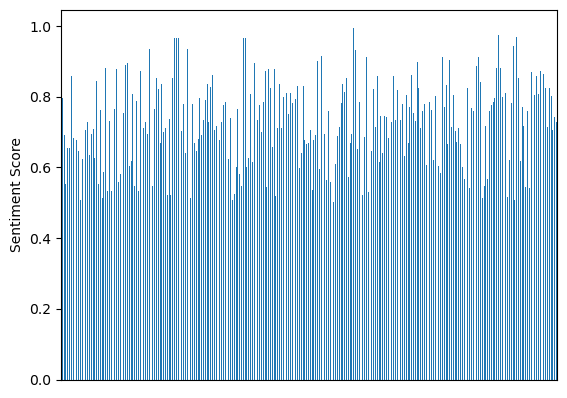

In [40]:
def reduce_for_text_sentiment(summaries):
    # Combine summaries into one text
    summary_text = " ".join(summaries)
    # Split the combined text into manageable chunks
    sentences = nltk.sent_tokenize(summary_text)
    df = pd.DataFrame(sentences, columns=['sentence'])
    #assign score to each sentence
    df['sentiment'] = df['sentence'].apply(lambda x: sentiment_analyzer(x)[0]['score'])

    # List to hold sentiment results
    df.to_excel("sentiments_LLM.xlsx", index=False)
    return df  

#read the text from the txt file
with open("Final_summaries.txt") as f:
    text = f.read()

df= reduce_for_text_sentiment(text)
print("Average Sentiment:", df['sentiment'].mean())
# Draw a bar chart
df["sentiment"].plot(kind="bar")
plt.xticks([])
plt.ylabel("Sentiment Score")
plt.show()
